# Dogs vs Cat Redux

[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)    

## Action Plan
### 1. [Data Preparation and Preprocessing] Create Validation and Sample sets
### 2. [Data Preparation and Preprocessing] Rearrange image files into their respective directories 
### 3. Finetune and Train model
### 4. Generate predictions
### 5. Validate predictions
### 6. Submit predictions to Kaggle

## 3. Model Finetuning and Training

In [1]:
#Verify we are in the correct directory
%cd "~/courses/deeplearning1/nbs"
%pwd

/home/ubuntu/courses/deeplearning1/nbs


'/home/ubuntu/courses/deeplearning1/nbs'

In [2]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
CODE_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir + '/../data/redux/'
print(CODE_HOME_DIR)
print(DATA_HOME_DIR)
#%mkdir "data/redux"

/home/ubuntu/courses/deeplearning1/nbs
/home/ubuntu/courses/deeplearning1/nbs/../data/redux/


In [3]:
#import modules
from importlib import reload

import utils; reload(utils)
from utils import *

import vgg16bn_ted; reload(vgg16bn_ted)
from vgg16bn_ted import Vgg16BN; 

%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 6021)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:631: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn(warn)
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Setup 

#### Setup Paths

In [4]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' # + '/sample/' 
test_path = path + '/test/' #We use all the test data
results_path = path + '/results/'
train_path = path + '/train/'
valid_path = path + '/valid/'
model_path = path + '/models/'
if not os.path.exists(model_path): os.mkdir(model_path)

/home/ubuntu/courses/deeplearning1/data/redux


## Start initial training

In [40]:
#import Vgg16 helper class
vgg = Vgg16BN()
model = vgg.model

model_name = 'Vgg16BN_ted'

In [41]:
batch_size=64

In [42]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, shuffle=False, batch_size=batch_size)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [44]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1

198/360 [===============>..............] - ETA: 1:50 - loss: 0.4665 - acc: 0.8545


360/360 [==============================] - 268s 743ms/step - loss: 0.4257 - acc: 0.8683 - val_loss: 0.1920 - val_acc: 0.9255


In [45]:
model.optimizer.lr = 0.1

In [47]:
vgg.fit(batches, val_batches, nb_epoch=3)

Epoch 1/3

198/360 [===============>..............] - ETA: 1:50 - loss: 0.3570 - acc: 0.8837


228/360 [==================>...........] - ETA: 1:30 - loss: 0.3572 - acc: 0.8829

KeyboardInterrupt: 

In [26]:
model.optimizer.lr = 0.01

In [27]:
vgg.fit(batches, val_batches, epoch=8)

Epoch 1/8
 - 316s - loss: 0.0683 - acc: 0.9827 - val_loss: 0.3027 - val_acc: 0.9510
Epoch 2/8
 - 314s - loss: 0.0586 - acc: 0.9838 - val_loss: 0.2574 - val_acc: 0.9570
Epoch 3/8
 - 315s - loss: 0.0485 - acc: 0.9863 - val_loss: 0.2582 - val_acc: 0.9535
Epoch 4/8
 - 315s - loss: 0.0460 - acc: 0.9875 - val_loss: 0.2518 - val_acc: 0.9545
Epoch 5/8


KeyboardInterrupt: 

## Data Augmentation

#### Adjust Data Augmentation parameters

In [15]:
# for display purposes, data_format='channels_last'this is more convenient
gen = image.ImageDataGenerator(rotation_range=20.0, width_shift_range=0.08, height_shift_range=0.08,
                              shear_range=0.15, zoom_range=0.1, channel_shift_range=10.,
                              horizontal_flip=True, data_format='channels_last')

In [18]:
# Create a 'batch' of a single image
img_orig = ndimage.imread(DATA_HOME_DIR+'test/unknown/10010.jpg')
img_orig_batch = np.expand_dims(img_orig, axis=0)


# Request the generator to create batches from this image
aug_iter = gen.flow(img_orig_batch)

# Get eight examples of these augmented images
aug_imgs = [np.squeeze(next(aug_iter), axis=0).astype(np.uint8) for i in range(8)]

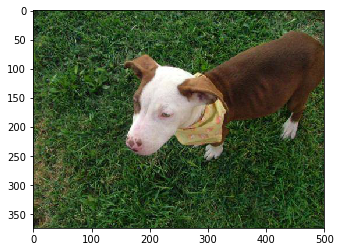

In [19]:
# original data
plt.imshow(img_orig)

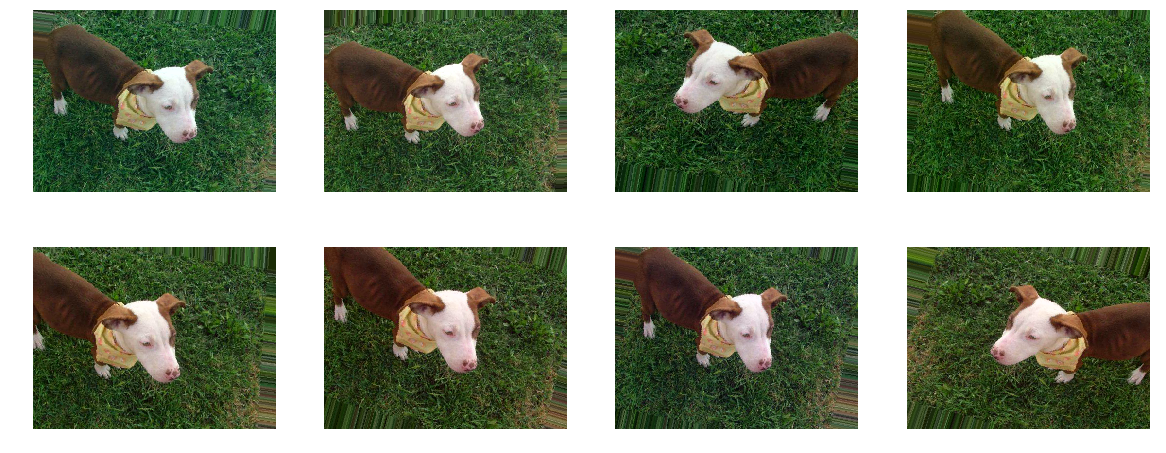

In [20]:
# Augmented data
plots(aug_imgs, (20,8), rows=2)

In [21]:
# Ensure that we return to channels first ordering
K.set_image_data_format('channels_first')

### Adding data augmentation to tune model

In [5]:
# for display purposes, data_format='channels_last'this is more convenient
gen = image.ImageDataGenerator(rotation_range=20.0, width_shift_range=0.08, height_shift_range=0.08,
                              shear_range=0.15, zoom_range=0.1, channel_shift_range=10.,
                              horizontal_flip=True)

In [6]:
#import Vgg16 helper class
vgg = Vgg16BN()
model = vgg.model

model_name = 'Vgg16BN_ted'

In [7]:
batch_size=64

In [8]:
#Finetune the model
batches = vgg.get_batches(train_path, gen, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, shuffle=False, batch_size=batch_size)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
vgg.fit(batches, val_batches, epochs=3)

Epoch 1/3
 - 303s - loss: 0.4837 - acc: 0.8441 - val_loss: 0.2198 - val_acc: 0.9210
Epoch 2/3
 - 291s - loss: 0.3948 - acc: 0.8691 - val_loss: 0.1877 - val_acc: 0.9295
Epoch 3/3
 - 291s - loss: 0.3915 - acc: 0.8684 - val_loss: 0.2106 - val_acc: 0.9215


In [10]:
model.optimizer.lr = 0.1

In [11]:
vgg.fit(batches, val_batches, epochs=3)

Epoch 1/3
 - 299s - loss: 0.3881 - acc: 0.8705 - val_loss: 0.2386 - val_acc: 0.9160
Epoch 2/3
 - 292s - loss: 0.3767 - acc: 0.8733 - val_loss: 0.2009 - val_acc: 0.9205
Epoch 3/3
 - 292s - loss: 0.3935 - acc: 0.8701 - val_loss: 0.2085 - val_acc: 0.9175


In [12]:
model.optimizer.lr = 0.01

In [14]:
vgg.fit(batches, val_batches, epochs=13)

Epoch 1/10
 - 300s - loss: 0.4016 - acc: 0.8710 - val_loss: 0.2209 - val_acc: 0.9170
Epoch 2/10
 - 293s - loss: 0.3847 - acc: 0.8740 - val_loss: 0.2332 - val_acc: 0.9220
Epoch 3/10
 - 292s - loss: 0.3947 - acc: 0.8720 - val_loss: 0.2185 - val_acc: 0.9215
Epoch 4/10
 - 295s - loss: 0.4035 - acc: 0.8666 - val_loss: 0.2083 - val_acc: 0.9250
Epoch 5/10
 - 294s - loss: 0.3969 - acc: 0.8688 - val_loss: 0.2785 - val_acc: 0.9090
Epoch 6/10
 - 293s - loss: 0.3979 - acc: 0.8694 - val_loss: 0.2014 - val_acc: 0.9240
Epoch 7/10
 - 293s - loss: 0.3838 - acc: 0.8752 - val_loss: 0.2119 - val_acc: 0.9200
Epoch 8/10
 - 291s - loss: 0.4000 - acc: 0.8703 - val_loss: 0.2659 - val_acc: 0.9035
Epoch 9/10
 - 292s - loss: 0.3932 - acc: 0.8694 - val_loss: 0.2297 - val_acc: 0.9200
Epoch 10/10
 - 294s - loss: 0.4050 - acc: 0.8733 - val_loss: 0.2132 - val_acc: 0.9275


In [15]:
model.save_weights(model_path + model_name + '-aug1.h5')

## Pretrain Convolution Layers to speed up training


<font color='red'>
** Notice that here because we use this BatchNormalization dense layers based on pretrained convolution layers, we can not use Data Augmentation, because with Data Augmentation the output of pretrained convolution layers will be different every time. **
</font>

In [5]:
vgg_conv = Vgg16BN(include_top=False)
conv_model = vgg_conv.model

conv_model_name = 'Vgg16BN_conv'

In [6]:
batch_size=64

#### Let's pretrain the conv_model first

In [20]:
batches = get_batches(train_path, shuffle=False, batch_size=batch_size)
val_batches = get_batches(valid_path, shuffle=False, batch_size=batch_size)

trn_classes = batches.classes
val_classes = val_batches.classes
trn_labels = onehot(trn_classes)
val_labels = onehot(val_classes)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [28]:
trn_features = conv_model.predict_generator(batches, steps=int(math.ceil(batches.n/batches.batch_size)))
val_features = conv_model.predict_generator(val_batches, steps=int(math.ceil(val_batches.n/val_batches.batch_size)))
#trn_features = conv_model.predict_generator(batches, steps=batches.n)
#val_features = conv_model.predict_generator(val_batches, steps=val_batches.n)

In [29]:
save_array(model_path+'train_convlayer_features.bc', trn_features)
save_array(model_path+'valid_convlayer_features.bc', val_features)

In [30]:
trn_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [31]:
trn_features.shape
#print(val_features.shape[0])
#print(conv_model.layers[-1].output_shape[1:])

(23000, 512, 7, 7)

In [32]:
def get_fc_model_bn():
    model = Sequential([
        # MaxPooling2D(input_shape=conv_model.layers[-1].output_shape[1:]),
        #BatchNormalization(),
        #Flatten(input_shape=conv_model.layers[-1].output_shape[1:]),
        Flatten(input_shape=trn_features.shape[1:]),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dense(2, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
fc_model = get_fc_model_bn()

In [34]:
print(batches.samples)
print(val_batches.samples)

23000
2000


In [35]:
#fc_model.fit(trn_features, trn_labels, epochs=2, batch_size=batch_size,
#             validation_data=(val_features, val_labels))
fc_model.fit(trn_features, trn_labels, batch_size=batch_size, epochs=2, 
             validation_data= (val_features, val_labels), verbose=2)

Train on 23000 samples, validate on 2000 samples
Epoch 1/2

 6080/23000 [======>.......................] - ETA: 43s - loss: 0.9141 - acc: 0.8788


12224/23000 [==============>...............] - ETA: 26s - loss: 0.5601 - acc: 0.8997


18368/23000 [======================>.......] - ETA: 11s - loss: 0.4359 - acc: 0.9095


23000/23000 [==============================] - 56s 2ms/step - loss: 0.3872 - acc: 0.9122 - val_loss: 0.1169 - val_acc: 0.9555
Epoch 2/2

 1472/23000 [>.............................] - ETA: 50s - loss: 0.1161 - acc: 0.9558


 7616/23000 [========>.....................] - ETA: 36s - loss: 0.1098 - acc: 0.9628


13760/23000 [================>.............] - ETA: 21s - loss: 0.1137 - acc: 0.9606


19904/23000 [========================>.....] - ETA: 7s - loss: 0.1071 - acc: 0.9628


23000/23000 [==============================] - 55s 2ms/step - loss: 0.1042 - acc: 0.9634 - val_loss: 0.1347 - val_acc: 0.9570
